In [15]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import string
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout, Embedding
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data=pd.read_csv(r'C:\Users\Banele\OneDrive\Desktop\SPAM\spam.csv', encoding='latin-1')
data.head()


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [17]:
import re

def preprocess_text(text):
    # Remove non-alphanumeric characters and convert to lowercase
    text = re.sub(r'\W', ' ', text)
    text = text.lower()
    return text

# Apply preprocessing to the message column
data['cleaned_message'] = data['v2'].apply(preprocess_text)

In [19]:
data.head(3)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4,cleaned_message
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN,go until jurong point crazy available only ...
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN,free entry in 2 a wkly comp to win fa cup fina...


In [23]:
# Check the shape of the dataset
print("Dataset Shape:", data.shape)


Dataset Shape: (5572, 6)


In [25]:
# Display the first few rows
print(data.head())


     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4                                    cleaned_message  
0        NaN        NaN  go until jurong point  crazy   available only ...  
1        NaN        NaN                      ok lar    joking wif u oni     
2        NaN        NaN  free entry in 2 a wkly comp to win fa cup fina...  
3        NaN        NaN  u dun say so early hor    u c already then say     
4        NaN        NaN  nah i don t think he goes to usf  he lives aro...  


In [27]:
# Check the distribution of classes
print(data['v1'].value_counts())

v1
ham     4825
spam     747
Name: count, dtype: int64


In [29]:
# Check for missing values
print(data.isnull().sum())

v1                    0
v2                    0
Unnamed: 2         5522
Unnamed: 3         5560
Unnamed: 4         5566
cleaned_message       0
dtype: int64


In [31]:
# Display basic statistics of the messages
print(data['v2'].describe())

count                       5572
unique                      5169
top       Sorry, I'll call later
freq                          30
Name: v2, dtype: object


In [33]:
# Drop unnecessary columns (Unnamed columns)
data = data[['v1', 'cleaned_message']]

# Rename columns for clarity
data.columns = ['label', 'message']


In [35]:
data.head(3)

,label,message
0,ham,go until jurong point crazy available only ...
1,ham,ok lar joking wif u oni
2,spam,free entry in 2 a wkly comp to win fa cup fina...


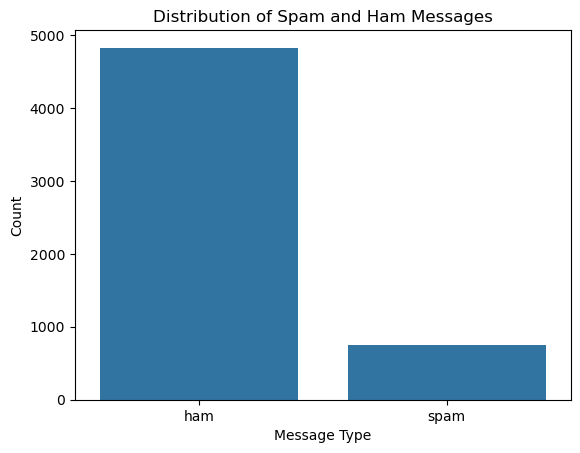

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='label', data=data)
plt.title('Distribution of Spam and Ham Messages')
plt.xlabel('Message Type')
plt.ylabel('Count')
plt.show()

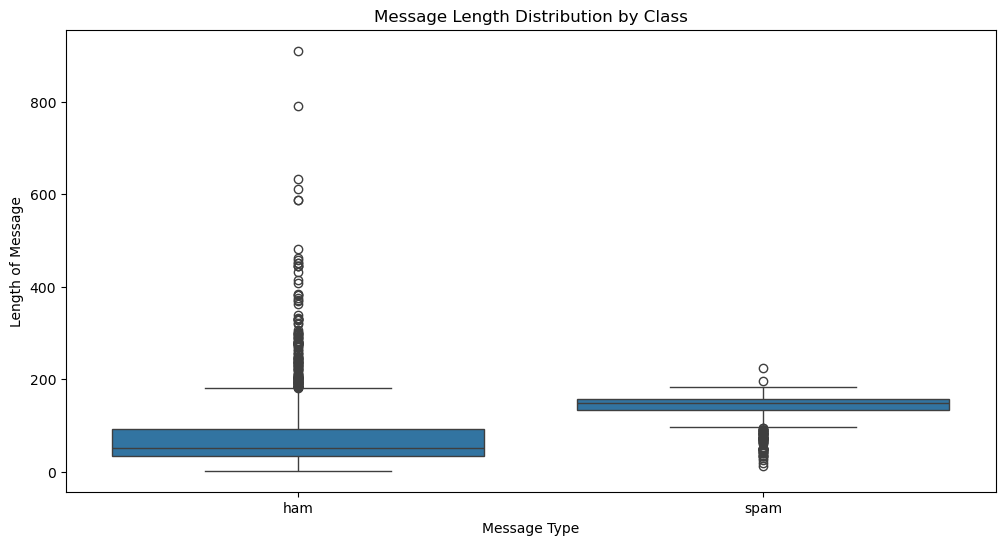

In [39]:
# Add a column for message length
data['message_length'] = data['message'].apply(len)

# Visualize message length
plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='message_length', data=data)
plt.title('Message Length Distribution by Class')
plt.xlabel('Message Type')
plt.ylabel('Length of Message')
plt.show()


In [41]:
# Display message length statistics
print(data['message_length'].describe())


count    5572.000000
mean       80.118808
std        59.690841
min         2.000000
25%        36.000000
50%        61.000000
75%       121.000000
max       910.000000
Name: message_length, dtype: float64


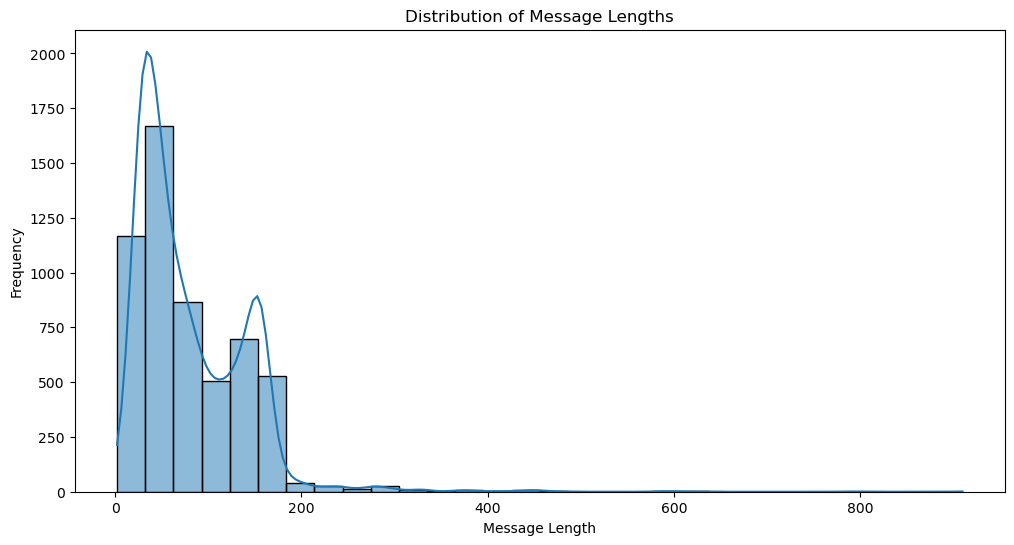

In [43]:
plt.figure(figsize=(12,6))
sns.histplot(data['message_length'], bins=30, kde=True)
plt.title('Distribution of Message Lengths')
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.show()

In [45]:
# Define thresholds for message length (based on IQR or custom values)
Q1 = data['message_length'].quantile(0.25)
Q3 = data['message_length'].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds for acceptable message lengths
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter data to remove outliers
filtered_data = data[(data['message_length'] >= lower_bound) & (data['message_length'] <= upper_bound)]
print(f"Original data size: {data.shape[0]}")
print(f"Filtered data size: {filtered_data.shape[0]}")


Original data size: 5572
Filtered data size: 5504


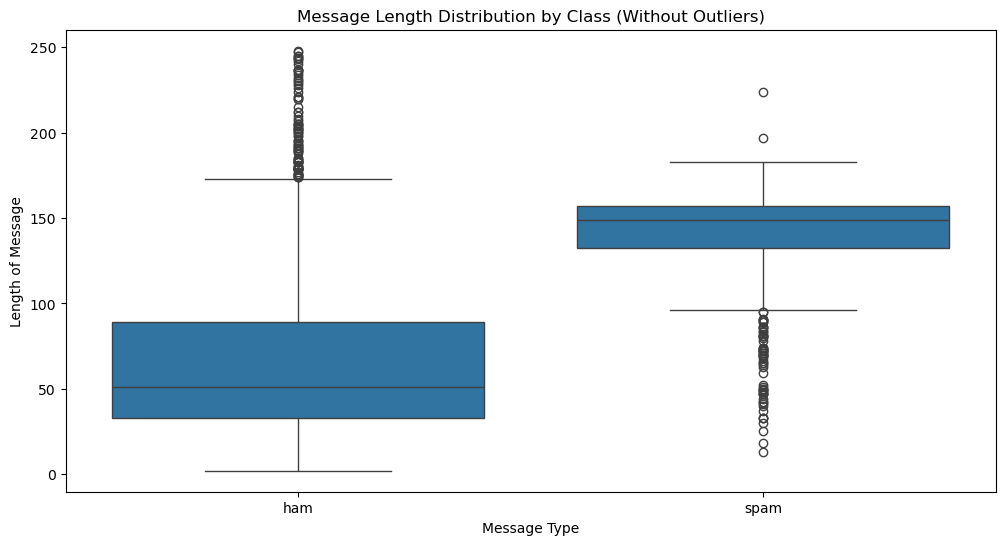

In [47]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='message_length', data=filtered_data)
plt.title('Message Length Distribution by Class (Without Outliers)')
plt.xlabel('Message Type')
plt.ylabel('Length of Message')
plt.show()


In [49]:
# Separate ham and spam messages
ham_messages = data[data['label'] == 'ham']
spam_messages = data[data['label'] == 'spam']

# Display statistics for both classes
print("Ham message length stats:")
print(ham_messages['message_length'].describe())

print("\nSpam message length stats:")
print(spam_messages['message_length'].describe())


Ham message length stats:
count    4825.000000
mean       71.023627
std        58.016023
min         2.000000
25%        33.000000
50%        52.000000
75%        92.000000
max       910.000000
Name: message_length, dtype: float64

Spam message length stats:
count    747.000000
mean     138.866131
std       29.183082
min       13.000000
25%      132.500000
50%      149.000000
75%      157.000000
max      224.000000
Name: message_length, dtype: float64


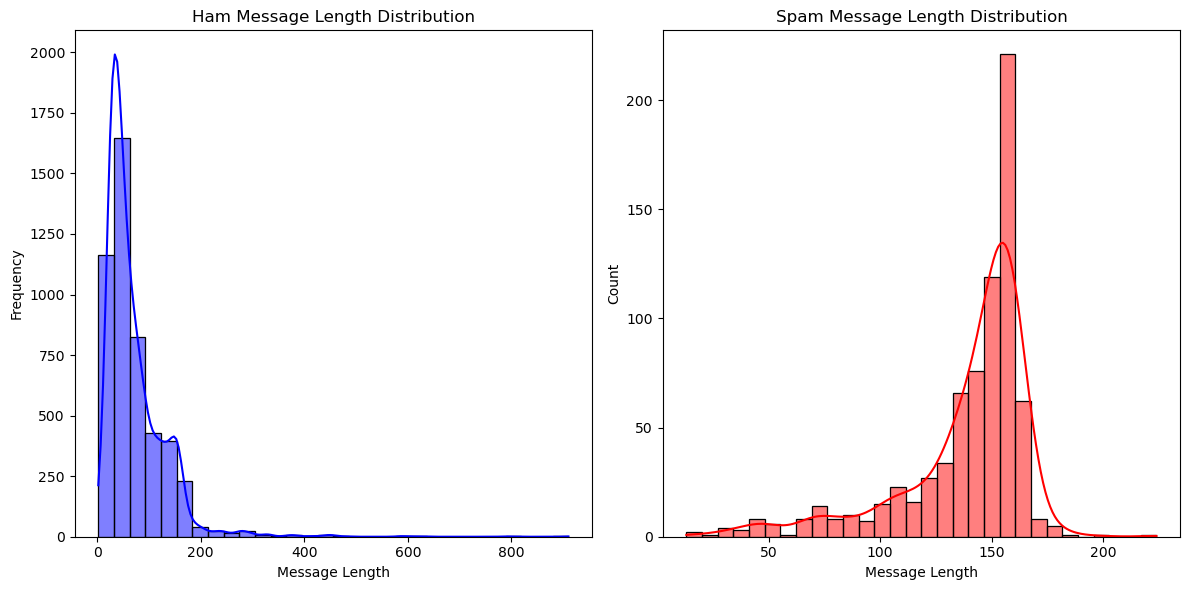

In [51]:
plt.figure(figsize=(12,6))

# Ham messages
plt.subplot(1, 2, 1)
sns.histplot(ham_messages['message_length'], bins=30, kde=True, color='blue')
plt.title('Ham Message Length Distribution')
plt.xlabel('Message Length')
plt.ylabel('Frequency')

# Spam messages
plt.subplot(1, 2, 2)
sns.histplot(spam_messages['message_length'], bins=30, kde=True, color='red')
plt.title('Spam Message Length Distribution')
plt.xlabel('Message Length')

plt.tight_layout()
plt.show()


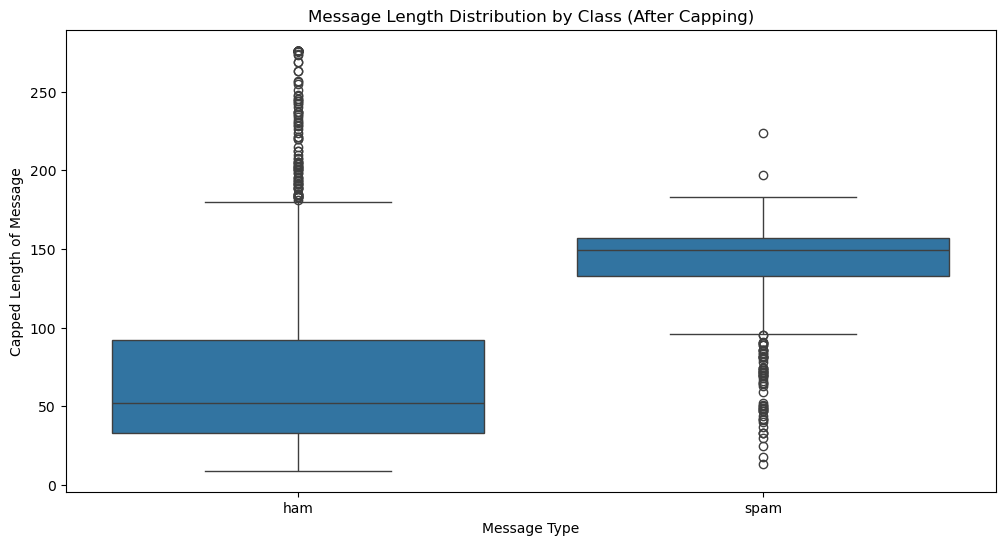

In [53]:
# Define capping thresholds (e.g., 99th percentile for upper bound)
upper_cap = data['message_length'].quantile(0.99)
lower_cap = data['message_length'].quantile(0.01)

# Cap the message lengths
data['capped_message_length'] = data['message_length'].apply(lambda x: upper_cap if x > upper_cap else (lower_cap if x < lower_cap else x))

# Check new distribution after capping
plt.figure(figsize=(12,6))
sns.boxplot(x='label', y='capped_message_length', data=data)
plt.title('Message Length Distribution by Class (After Capping)')
plt.xlabel('Message Type')
plt.ylabel('Capped Length of Message')
plt.show()


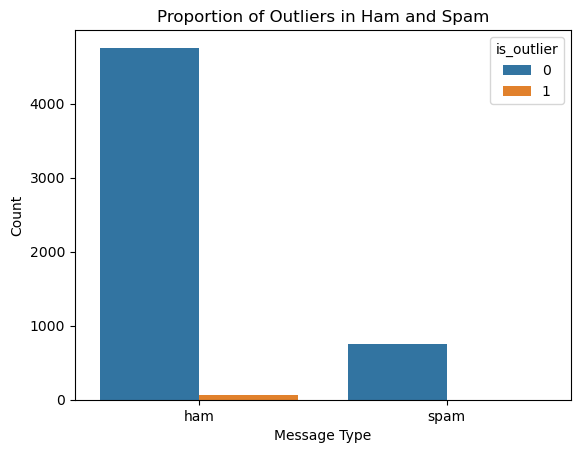

In [55]:
# Add a column for outlier detection
data['is_outlier'] = ((data['message_length'] < lower_bound) | (data['message_length'] > upper_bound)).astype(int)

# Visualize the proportion of outliers in each class
sns.countplot(x='label', hue='is_outlier', data=data)
plt.title('Proportion of Outliers in Ham and Spam')
plt.xlabel('Message Type')
plt.ylabel('Count')
plt.show()


In [61]:
data.head(2)

,label,message,message_length,capped_message_length,is_outlier
0,ham,go until jurong point crazy available only ...,111,111.0,0
1,ham,ok lar joking wif u oni,29,29.0,0


In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Using the original message and the additional features for classification
X = data[['message', 'capped_message_length', 'is_outlier']]
y = data['label']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X['message'], y, test_size=0.2, random_state=42)

# Vectorize the message content using TF-IDF
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Train models as described earlier (Naive Bayes, Logistic Regression, etc.)


In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000)  # Limit to top 5000 features for efficiency

# Transform the message data into TF-IDF features
X_tfidf = tfidf.fit_transform(data['message'])

# Check shape of the TF-IDF matrix
print(X_tfidf.shape)


(5572, 5000)


In [65]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, data['label'], test_size=0.2, random_state=42)

# Check the sizes of training and test sets
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)


Training set size: (4457, 5000)
Test set size: (1115, 5000)


Naive Bayes Accuracy: 0.9704035874439462
Classification Report:
              precision    recall  f1-score   support

         ham       0.97      1.00      0.98       965
        spam       1.00      0.78      0.88       150

    accuracy                           0.97      1115
   macro avg       0.98      0.89      0.93      1115
weighted avg       0.97      0.97      0.97      1115

Confusion Matrix:
[[965   0]
 [ 33 117]]


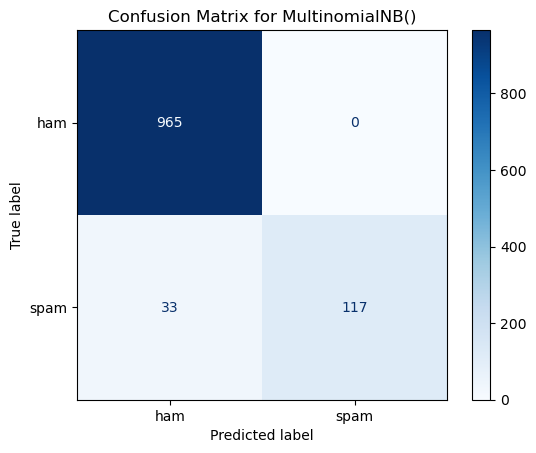

In [82]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize and train the Naive Bayes model
nb = MultinomialNB()
nb.fit(X_train, y_train)

# Make predictions
y_pred_nb = nb.predict(X_test)

# Evaluate the model
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Classification Report:")
print(classification_report(y_test, y_pred_nb))

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_nb), display_labels=['ham', 'spam'])
disp.plot(cmap='Blues')
plt.title(f'Confusion Matrix for {nb}')
plt.show()

Logistic Regression Accuracy: 0.9632286995515695
Classification Report:
              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       965
        spam       1.00      0.73      0.84       150

    accuracy                           0.96      1115
   macro avg       0.98      0.86      0.91      1115
weighted avg       0.96      0.96      0.96      1115



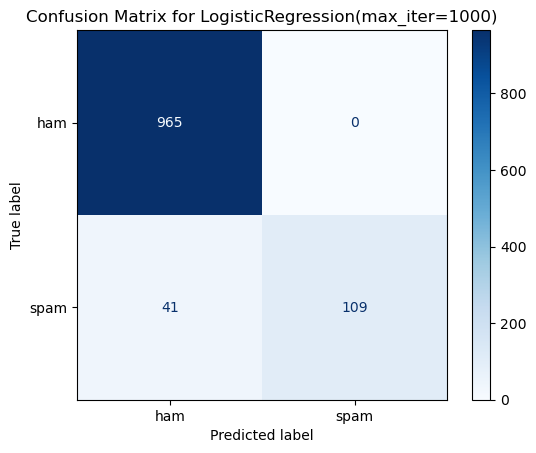

In [100]:
from sklearn.linear_model import LogisticRegression

# Initialize and train the Logistic Regression model
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

# Make predictions
y_pred_lr = lr.predict(X_test)

# Evaluate the model
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Classification Report:")
print(classification_report(y_test, y_pred_lr))

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_lr), display_labels=['ham', 'spam'])
disp.plot(cmap='Blues')
plt.title(f'Confusion Matrix for {lr}')
plt.show()

SVM Accuracy: 0.9775784753363229
Classification Report:
              precision    recall  f1-score   support

         ham       0.97      1.00      0.99       965
        spam       1.00      0.83      0.91       150

    accuracy                           0.98      1115
   macro avg       0.99      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115

Confusion Matrix:
[[965   0]
 [ 25 125]]


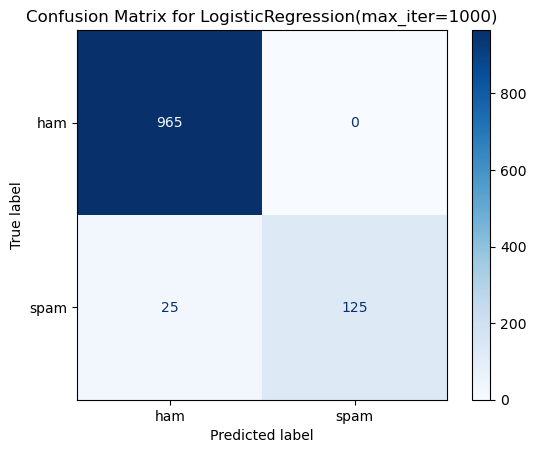

In [102]:
from sklearn.svm import SVC

# Initialize and train the SVM model
svm = SVC()
svm.fit(X_train, y_train)

# Make predictions
y_pred_svm = svm.predict(X_test)

# Evaluate the model
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Classification Report:")
print(classification_report(y_test, y_pred_svm))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_svm), display_labels=['ham', 'spam'])
disp.plot(cmap='Blues')
plt.title(f'Confusion Matrix for {lr}')
plt.show()

In [110]:
# Print accuracy for all models
print("Naive Bayes Accuracy:", round(accuracy_score(y_test, y_pred_nb),4))
print("Logistic Regression Accuracy:", round(accuracy_score(y_test, y_pred_lr),4))
print("SVM Accuracy:", round(accuracy_score(y_test, y_pred_svm),4))


Naive Bayes Accuracy: 0.9704
Logistic Regression Accuracy: 0.9632
SVM Accuracy: 0.9776


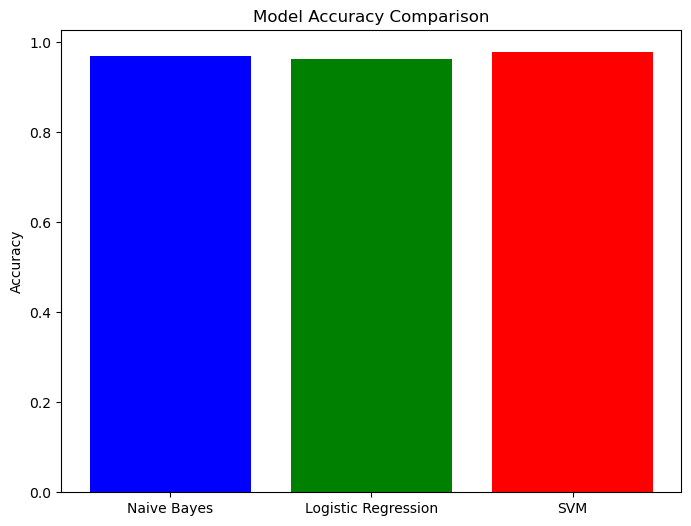

In [75]:
import matplotlib.pyplot as plt

# Accuracy comparison
accuracies = [accuracy_score(y_test, y_pred_nb), accuracy_score(y_test, y_pred_lr), accuracy_score(y_test, y_pred_svm)]
models = ['Naive Bayes', 'Logistic Regression', 'SVM']

plt.figure(figsize=(8,6))
plt.bar(models, accuracies, color=['blue', 'green', 'red'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.show()


In [114]:
# Convert 'ham' and 'spam' to binary labels
y_test_binary = y_test.replace({'ham': 0, 'spam': 1})

# Get predicted probabilities again
y_prob_nb = nb.predict_proba(X_test)[:, 1]  # Naive Bayes probabilities
y_prob_lr = lr.predict_proba(X_test)[:, 1]  # Logistic Regression probabilities
y_prob_svm = svm.decision_function(X_test)  # SVM decision function (since SVM doesn't have predict_proba)

# Calculate AUC for each model using the binary labels
auc_nb = roc_auc_score(y_test_binary, y_prob_nb)
auc_lr = roc_auc_score(y_test_binary, y_prob_lr)
auc_svm = roc_auc_score(y_test_binary, y_prob_svm)

print("Naive Bayes AUC:", round(auc_nb,4))
print("Logistic Regression AUC:", round(auc_lr,4))
print("SVM AUC:", round(auc_svm,4))


C:\Users\Banele\AppData\Local\Temp\ipykernel_21880\795979591.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_test_binary = y_test.replace({'ham': 0, 'spam': 1})


Naive Bayes AUC: 0.9817
Logistic Regression AUC: 0.9844
SVM AUC: 0.9877


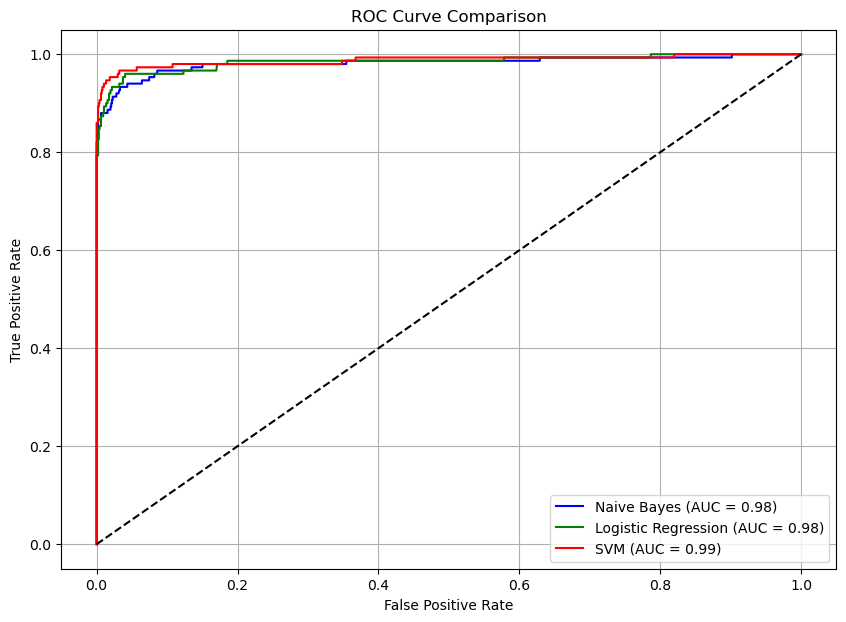

In [96]:
# Plot ROC curves
fpr_nb, tpr_nb, _ = roc_curve(y_test_binary, y_prob_nb)
fpr_lr, tpr_lr, _ = roc_curve(y_test_binary, y_prob_lr)
fpr_svm, tpr_svm, _ = roc_curve(y_test_binary, y_prob_svm)

plt.figure(figsize=(10, 7))

# Plot ROC for Naive Bayes
plt.plot(fpr_nb, tpr_nb, label=f"Naive Bayes (AUC = {auc_nb:.2f})", color='blue')

# Plot ROC for Logistic Regression
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {auc_lr:.2f})", color='green')

# Plot ROC for SVM
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {auc_svm:.2f})", color='red')

# Plot ROC curve diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--')

# Label the plot
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [ ]:
# THEREFOFRE TRHE SVM IS CHOSEN AS THE BEST MODEL BASED TO AUC
# AND ALSO BASED TO ACCURACY